# Check DataSet

In [1]:
import pandas as pd
import numpy as np
import csv
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import re

In [2]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

In [3]:
data_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


# import textaugment library.
TextAugment is a Python 3 library for augmenting text for natural language processing applications. TextAugment stands on the giant shoulders of NLTK, Gensim, and TextBlob and plays nicely with them.

# Settings

In [4]:
#control the numer of words that can be passes to model
max_sequence_length = 30
#limit dictionary of words to 3000
max_words = 3000
#define the size of output vector from this layer for each word
embedding_size = 30
#once trained, the weights of LSTM neural network will be saved in a h5 file.
#so that you can reuse this model later
model_file = 'model.h5'
#store the word  dictionary and in the process of converting text to strings and backwoards
tokenizer_file = 'tokenizer.pickle'
#binary classification
num_classes = 2

# Text cleaning

In [5]:
def clean_str(string):
    #replace and simplify a lot of signals
    string = re.sub(r'http\S+', 'link', string) # replace links by generic text link
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    cleanr = re.compile('<.*?>')

    string = re.sub(r'\d+', '', string)
    string = re.sub(cleanr, '', string)
    string = re.sub("'", '', string)
    string = re.sub(r'\W+', ' ', string)
    string = string.replace('_', '')
    #turn to lower case
    return string.strip().lower()

In [6]:
cleaned_str = clean_str('Horrible Accident | Man Died In Wings of AirplaneåÊ(29-07-2015) http://t.co/wq3wJsgPHL')
cleaned_str

'horrible accident man died in wings of airplane link'

# Remove stopwords

In [7]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(word_list):
    no_stop_words = [w for w in word_list if not w in stop_words]
    return no_stop_words


In [8]:
remove_stopwords(cleaned_str.split(" "))

['horrible', 'accident', 'man', 'died', 'wings', 'airplane', 'link']

# Data augmentation

In [9]:
#import and create an EDA example
from textaugment import EDA
t = EDA()


unable to import 'smart_open.gcs', disabling that module


Random Deletion (RD): Randomly remove each word in the sentence with probability p.

In [10]:
for i in range(3):
    print(t.random_deletion('The pastor was not in the scene of the accident... who was the owner of the range rover?', p=0.2))

pastor was not in the scene of who was the of the range rover?
The not in the scene of accident... who was the owner of the range
The pastor was in the of the accident... who was the owner of the range rover?


Random Swap (RS): Randomly choose two words in the sentence and swap their positions. Do this n times.¶

In [11]:
for i in range(3):
    print(t.random_swap('The pastor was not in the scene of the accident... who was the owner of the range rover?'))

The pastor was not in the scene of the accident... who was range owner of the the rover?
The the was not in the scene of the accident... who was the owner of pastor range rover?
The pastor was not in the scene the the accident... who was of owner of the range rover?


Synonym Replacement (SR): Randomly choose n words from the sentence that are not stop words. Replace each of these words with one of its synonyms chosen at random.¶

In [12]:
for i in range(3):
    print(t.synonym_replacement('The pastor was not in the scene of the accident... who was the owner of the range rover?'))

The minister of religion was not in the scene of the accident... who was the owner of the range rover?
The pastor was not in the scene of the accident... who was the owner of the mountain chain rover?
The pastor was not in the scene of the accident... who was the owner of the tramp rover?


Random Insertion (RI): Find a random synonym of a random word in the sentence that is not a stop word. Insert that synonym into a random position in the sentence. Do this n times.

In [13]:
for i in range(3):
    print(t.random_insertion('The pastor was not in the scene of the accident... who was the owner of the range rover?'))

The pastor was not in the scene of the accident... who was possessor the owner of the range rover?
The pastor was not in lay out the scene of the accident... who was the owner of the range rover?
The pastor was not in the scene of the accident... who was the owner of the minister of religion range rover?


# Load dataset

In [14]:
data_train = data_train[['text', 'target']]

In [15]:
data_train

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


Text(0.5, 1.0, 'Number of disaster tweets')

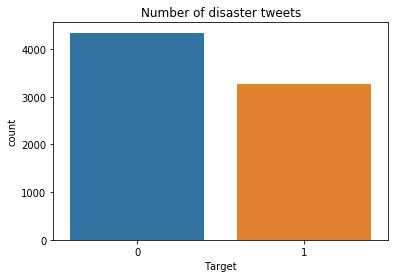

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data_train.target)
plt.xlabel('Target')
plt.title('Number of disaster tweets')

In [18]:
data_train['text'] = data_train['text'].apply(lambda x: clean_str(x))

sequences = []
targets = []

for index, row in data_train.iterrows():
    seqs = []
    text = row['text']

    # if empty text, skipping to next row data
    if not text:
        continue

    seqs.append(text)
    
    # apply data augmentation
    
    # random deletion
    seq2 = t.random_deletion(text, p=0.2)
    if type(seq2) == type([]):
        seqs.append(seq2[0])
    else:
        seqs.append(seq2)
        # random swap
    if len(text) > 1:
        seqs.append(t.random_swap(text))

    # synonym replacement and random insertion
    for i in range(2):
        seqs.append(t.synonym_replacement(text))    
        try:
            seqs.append(t.random_insertion(text))
        except:
            pass
    """
    All sequence variations created in the data augmentation process are grouped in bags. 
    This is important to avoid that in the process of splitting the data, variations of 
    the same sequence are allocated in different sets. For example, an X variation of 
    sequence A falls in the training set and an Y variation of sequence A falls in the test set.
    """
    sequence_group = []
    target_group = []

    target = row['target']

    for sequence in seqs: 
        word_list = text_to_word_sequence(sequence)
        
        # remove stop words
        no_stop_words = remove_stopwords(word_list)
        
        if not no_stop_words:
            continue

        sequence_group.append(" ".join(no_stop_words))
        target_group.append(target)

    sequences.append(sequence_group)
    targets.append(target_group)


X = sequences
Y = np.array(targets)

print("{bags_count} bags".format(bags_count=len(X)))


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


7613 bags


In [19]:
X

[['deeds reason earthquake may allah forgive us',
  'reason earthquake may allah forgive us',
  'deeds reason earthquake may allah forgive us',
  'act reason earthquake may allah forgive us',
  'deeds reason title earthquake may allah forgive us',
  'act reason earthquake may allah forgive us',
  'deeds reason usa earthquake may allah forgive us'],
 ['forest fire near la ronge sask canada',
  'forest near la ronge sask canada',
  'forest sask near la ronge fire canada',
  'forest fire come la ronge sask canada',
  'wood forest fire near la ronge sask canada',
  'forest fire near pelican state ronge sask canada',
  'forest fire near la ronge sask wood canada'],
 ['residents asked shelter place notified officers evacuation shelter place orders expected',
  'residents shelter place notified shelter place orders',
  'residents asked shelter place notified officers evacuation shelter place orders expected',
  'residents demand shelter place notified officers evacuation shelter place orders 

# Split data into train, validation and test sets

Training Dataset:
The sample of data used to fit the model.

Validation Dataset:
The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.

Test Dataset:
The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25,
                                                    random_state=42)

X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.25,
                                                    random_state=42)

X_train = [item for sublist in X_train for item in sublist]
Y_train = [item for sublist in Y_train for item in sublist]

X_validation = [item for sublist in X_validation for item in sublist]
Y_validation = [item for sublist in Y_validation for item in sublist]

X_test = [item for sublist in X_test for item in sublist]
Y_test = [item for sublist in Y_test for item in sublist]

print("Train: {train_size}\nValidation: {validation_size}\nTest: {test_size}\n".format(train_size=len(X_train), validation_size=len(X_validation), test_size=len(X_test)))

Train: 29943
Validation: 9988
Test: 13312



In [37]:
X_train[0]

'xgn infinity ronin carbon hahah mutual host preset bal nades radar demolish'

In [38]:
# tokenizer
tokenizer = Tokenizer(num_words=max_words)  

# Updates internal vocabulary based on a list of texts. 
# This method creates the vocabulary index based on word frequency. 
tokenizer.fit_on_texts(X_train)

# Transforms each row from texts to a sequence of integers. 
# So it basically takes each word in the text and replaces it 
# with its corresponding integer value from the
X_train = tokenizer.texts_to_sequences(X_train)
X_validation = tokenizer.texts_to_sequences(X_validation)
X_test = tokenizer.texts_to_sequences(X_test)


# Pad sequences
X_train = pad_sequences(X_train, maxlen=max_sequence_length, dtype='int32', value=0)
X_validation = pad_sequences(X_validation, maxlen=max_sequence_length, dtype='int32', value=0)
X_test = pad_sequences(X_test, maxlen=max_sequence_length, dtype='int32', value=0)

word_index = tokenizer.word_index

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_validation = np.array(X_validation)
Y_validation = np.array(Y_validation)
X_test = np.array(X_test)
Y_test = np.array(Y_test)


# LSTM Model

In [39]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2

l2_reg = l2(0.001)

def model_fn():
    model = Sequential()

    model.add(Embedding(max_words, embedding_size, input_length=max_sequence_length, embeddings_regularizer=l2_reg))
    
    model.add(SpatialDropout1D(0.5))
    
    model.add(LSTM(32, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2_reg, recurrent_regularizer=l2_reg, bias_regularizer=l2_reg))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(512, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))
    optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    print(model.summary())

    return model

# Training

In [40]:
import os
import numpy as np
import pickle

# epochs
epochs = 10

# number of samples to use for each gradient update
batch_size = 128

# saving tokenizer
with open(tokenizer_file, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model = model_fn()

# loadin saved model
if os.path.exists(model_file):
    model.load_weights(model_file)

history = model.fit(X_train, Y_train,
          validation_data=(X_validation, Y_validation),
          epochs=epochs,
          batch_size=batch_size,
          shuffle=True,
          verbose=1)

# saving model
model.save_weights(model_file)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 30)            90000     
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 30, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               16896     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 115,473
Trainable params: 115,473
Non-trainable params: 0
________________________________________________

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


29943/29943 [==============================] - 6s 213us/sample - loss: 0.6044 - accuracy: 0.7162 - val_loss: 0.5769 - val_accuracy: 0.7384
Epoch 2/10
29943/29943 [==============================] - 5s 155us/sample - loss: 0.5429 - accuracy: 0.7592 - val_loss: 0.5430 - val_accuracy: 0.7597
Epoch 3/10
29943/29943 [==============================] - 4s 146us/sample - loss: 0.5063 - accuracy: 0.7831 - val_loss: 0.5279 - val_accuracy: 0.7673
Epoch 4/10
29943/29943 [==============================] - 4s 146us/sample - loss: 0.4821 - accuracy: 0.8018 - val_loss: 0.5110 - val_accuracy: 0.7770
Epoch 5/10
29943/29943 [==============================] - 4s 147us/sample - loss: 0.4646 - accuracy: 0.8116 - val_loss: 0.5071 - val_accuracy: 0.7776
Epoch 6/10
29943/29943 [==============================] - 5s 151us/sample - loss: 0.4514 - accuracy: 0.8210 - val_loss: 0.4991 - val_accuracy: 0.7881
Epoch 7/10
29943/29943 [==============================] - 5s 154us/sample - loss: 0.4373 - accuracy: 0.8271 - v

# Show loss and accuracy

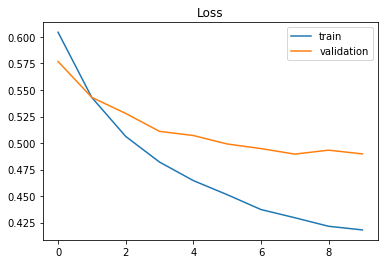

In [41]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

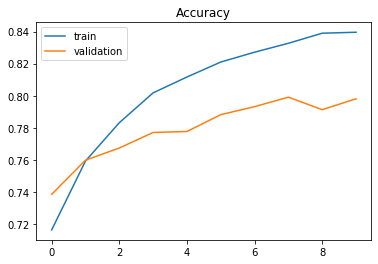

In [42]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [43]:
# evaluate model
scores = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print("Acc: %.2f%%" % (scores[1] * 100))

Acc: 78.20%


# create submission

In [46]:
test = pd.read_csv('test.csv')

# Clear text
test['text'] = test['text'].apply(lambda x: clean_str(x))

# Remove stop words
test['text'] = test['text'].apply(lambda x: " ".join(remove_stopwords(x.split(" "))))

# Get text
test_X = list(test["text"])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences
sequences = pad_sequences(sequences,
                             maxlen=max_sequence_length,
                             dtype='int32',
                             value=0)

# Predict sequences
predicted = model.predict(sequences)

binary_predicted = np.array(predicted) >= 0.5
targets = binary_predicted.astype(int).reshape((len(binary_predicted)))
my_submission = pd.DataFrame({'id': test.id, 'target': targets})
my_submission.to_csv('submission.csv', index=False)

print("Submission file created!")

Submission file created!
